In [1]:
import numpy as np
import pandas as pd
import os
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime


data_folder = '../data/Car Hacking Dataset/'

def hex_to_bin(hex_num):
    
    binary_value = bin(int(str(hex_num), 16))[2:]
    
    return binary_value

def int_to_bin(int_num):
    
    binary_value = bin(int_num)[2:]
    
    return binary_value

hex_to_dec = lambda x: int(x, 16)
dec_to_hex = lambda x : hex(int(x))[2:]

In [2]:
def read_data(data_path):
    
    columns = ['Timestamp','ID', 'DLC', 'Payload', 'label']
    
    data = pd.read_csv(data_path)
    
    ##Replacing all NaNs with '00' 
    data = data.replace(np.NaN, '00')

    data['ID'] = data['ID'].apply(hex_to_dec)
    
    data['Payload'] = data['Payload'].str.replace(' ', '')
    data['Payload'] = data['Payload'].apply(hex_to_dec)
    
    data = data.assign(IAT=data['Timestamp'].diff().fillna(0))
    
    return data

In [3]:
normal_data = read_data(os.path.join(data_folder, 'benign_data.csv'))
normal_data = normal_data[:100_000]

In [4]:
normal_data.shape

(100000, 6)

In [4]:
normal_data['ID'].unique()

array([ 848,  704, 1072, 1201,  497,  339,    2,  399,  304,  305,  320,
        608,  672,  790,  809, 1349,  688, 1087,  880, 1088, 1264, 1520,
       1440, 1442, 1680,  160,  161])

In [6]:
# hex(1264)

'0x4f0'

In [7]:
# {1087: 1.0033919009407861, 880: 0.9781937532449738, 1088: 0.954903614766108, 848: 0.908488352101319, 1680: 0.8591817879935414, 1264: 0.7650031280246349, 160: 0.7614517368657472, 161: 0.7591690264830223, 1520: 0.5356818535941872, 339: 0.5091289519073878, 2: 0.4831392322111201, 704: 0.45899605732551624, 688: 0.41908918003054046, 304: 0.3959048351464078, 305: 0.37220563412800184, 320: 0.3478149755553426, 790: 0.30470273486024163, 1072: 0.28856369466290727, 399: 0.2814349893753423, 1201: 0.27856245619444464, 497: 0.2668199290206168, 608: 0.2584500410593491, 672: 0.23410832242892185, 809: 0.21079770288926025, 1440: 0.20352009571555088, 1442: 0.2031775391197506, 1349: 0.18628849267192854}


{1087: 1.0033919009407861,
 880: 0.9781937532449738,
 1088: 0.954903614766108,
 848: 0.908488352101319,
 1680: 0.8591817879935414,
 1264: 0.7650031280246349,
 160: 0.7614517368657472,
 161: 0.7591690264830223,
 1520: 0.5356818535941872,
 339: 0.5091289519073878,
 2: 0.4831392322111201,
 704: 0.45899605732551624,
 688: 0.41908918003054046,
 304: 0.3959048351464078,
 305: 0.37220563412800184,
 320: 0.3478149755553426,
 790: 0.30470273486024163,
 1072: 0.28856369466290727,
 399: 0.2814349893753423,
 1201: 0.27856245619444464,
 497: 0.2668199290206168,
 608: 0.2584500410593491,
 672: 0.23410832242892185,
 809: 0.21079770288926025,
 1440: 0.20352009571555088,
 1442: 0.2031775391197506,
 1349: 0.18628849267192854}

In [8]:
## Function to calculate average time and frequency of each message ID
## In this function frequency is defined as the number of packets a particular message ID has
## Average time is defined as the average time between two packets of the same message ID



In [4]:
def calculate_periodicity(df):
    # Initialize an empty dictionary to store the periodicity for each can_id
    periodicity_dict = {}

    # Group the DataFrame by 'can_id'
    grouped = df.groupby('ID')

    for can_id, group_df in grouped:
        # Sort the DataFrame by 'timestamp'
        sorted_df = group_df.sort_values(by='Timestamp')

        # Calculate the periodicity for the current can_id
        first_timestamp = sorted_df.iloc[0]['Timestamp']
        last_timestamp = sorted_df.iloc[-1]['Timestamp']
        num_occurrences = len(sorted_df)

        if num_occurrences > 1:
            periodicity = (last_timestamp - first_timestamp) / (num_occurrences - 1)
        else:
            periodicity = 0  # Avoid division by zero if there's only one occurrence

        # Store the periodicity in the dictionary
        periodicity_dict[can_id] = periodicity

    return periodicity_dict

def calculate_inverse_periodicity(periodicity_dict):
    
    inverse_periodicity_dict = {id: 1.0 / periodicity for id, periodicity in periodicity_dict.items()}
    
    return inverse_periodicity_dict

In [5]:
def injection_possible(inter_arrival_time):

    #This is the time that it would take a fully stuffed frame to be transmitted 
    #to the bus at 512kbps 
    # 8 Bytes
    time_to_transmit = 0.000255
    
    # #5 bytes
    # time_to_transmit = 0.000209

    # 2 Bytes
    # time_to_transmit = 0.000177

    num_injections = (inter_arrival_time - time_to_transmit) // time_to_transmit

    if num_injections >= 1:
        return (True, num_injections)
    else:
        return (False, 0)

In [6]:
normal_data['Timestamp'] = pd.to_datetime(normal_data['Timestamp'], unit='s')

# Format the Timestamp column to display in minutes:seconds:milliseconds
normal_data['Timestamp'] = normal_data['Timestamp'].dt.strftime('%M:%S:%f')

normal_data.head()

Timestamp    ID  DLC              Payload  label       IAT
0  03:54:850202   848    8   371692544708313250      0  0.000000
1  03:54:850423   704    8  1441151880758558720      0  0.000221
2  03:54:850977  1072    8                    0      0  0.000554
3  03:54:851214  1201    8                    0      0  0.000238
4  03:54:851463   497    8                    0      0  0.000248

In [7]:
timestamps = normal_data['Timestamp']
iat_values = normal_data['IAT']
possible_injections = []

for i in range(1, len(iat_values)):
    inter_arrival_time = iat_values[i]
    is_possible, num_injections = injection_possible(inter_arrival_time)
    possible_injections.append(num_injections)

In [6]:
# Plotting
plt.figure(figsize=(21, 6))
plt.plot(timestamps[1:], possible_injections, marker='o', linestyle='-', color='b')
plt.title('Possible Injections Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Number of Injections Possible')
plt.grid(True)
plt.xticks([])
plt.tight_layout()
plt.show()

NameError: name 'timestamps' is not defined

<Figure size 2100x600 with 0 Axes>

In [8]:
def calculate_atr(data, ts, periodicity_dict):

    atr_dict = dict()

    """data : The dataflow until the time at which decision to inject packet is taken"""

    ids = list(periodicity_dict.keys())

    last_occurrences = data.drop_duplicates(subset='ID', keep='last')

    for id in ids:

        last_occurrence = last_occurrences[last_occurrences['ID'] == id]['Timestamp']
        
        atr = (ts - last_occurrence)/periodicity_dict[id]

        if len(atr.values) == 0:
            atr = 0.0
        else:
            atr = atr.item()
    
        atr_dict[id] = atr
            
    return atr_dict

In [9]:
# normal_data[normal_data['ID'] == 848]['Timestamp'].diff().iloc[1:]

normal_data = read_data(os.path.join(data_folder, 'benign_data.csv'))

In [10]:
periodicity_dict = calculate_periodicity(normal_data)

In [11]:
periodicity_dict

{2: 0.009999374838108484,
 160: 0.09991636647024356,
 161: 0.09991636275304053,
 304: 0.009999386366898521,
 305: 0.009999385698426417,
 320: 0.009999385463048915,
 339: 0.009999375012287835,
 399: 0.009991597443453322,
 497: 0.019998750109311573,
 608: 0.009991582805118908,
 672: 0.009991582880380268,
 688: 0.010007501432940654,
 704: 0.009991154394517041,
 790: 0.009991564812950162,
 809: 0.009991578612676136,
 848: 0.009996650847718502,
 880: 0.010000440840849192,
 1072: 0.019998751691048384,
 1087: 0.010000450473637753,
 1088: 0.010000445379465112,
 1201: 0.019998750467085373,
 1264: 0.019999802769334447,
 1349: 0.009991578495077943,
 1440: 0.9991146302505916,
 1442: 0.9991144031404036,
 1520: 0.04999964574784464,
 1680: 0.0999989960237428}

In [12]:
min(periodicity_dict.values())

0.009991154394517041

In [13]:
normal_data = normal_data.drop(columns=['IAT'],axis = 1)

In [14]:
normal_data

Timestamp    ID  DLC               Payload  label
0       1.479121e+09   848    8    371692544708313250      0
1       1.479121e+09   704    8   1441151880758558720      0
2       1.479121e+09  1072    8                     0      0
3       1.479121e+09  1201    8                     0      0
4       1.479121e+09   497    8                     0      0
...              ...   ...  ...                   ...    ...
988866  1.479122e+09   688    5          738819049343      0
988867  1.479122e+09   790    8    376068213553234298      0
988868  1.479122e+09   399    8  18316421159497433088      0
988869  1.479122e+09   608    8   3618705183201253660      0
988870  1.479122e+09   672    8   2305971776645291264      0

[988871 rows x 5 columns]

In [15]:
normal_data = normal_data[0:100_000]

In [16]:
## Threshold same or different for different IDs?


##Assuming we know when the next packet comes using periodicity dict/ lookahead,
## In actual it will shift packets or we change approach?

def attack(data, thresh = 0.75):

    pass

standby_packets = 10_000

threshold = 0.5

comparision_count = 0


out = []
lb1_count = 0 
for ind in range(len(normal_data)):
    
    print(f"{ind} out of {len(normal_data)}: {ind/len(normal_data)*100}%")

    if ind <= standby_packets:
        out.append(normal_data.iloc[ind].values)
    
    else:
        curr_ts = normal_data['Timestamp'][ind]
        prev_ts = normal_data['Timestamp'][ind - 1]

        curr_iat = curr_ts - prev_ts

        if injection_possible(curr_iat)[0]:
           
            periodicity_dict = calculate_periodicity(normal_data[:ind])

            atr_dict =  calculate_atr(normal_data[:ind], curr_ts, periodicity_dict)

            # print(atr_dict)
          
            attack_id = max(atr_dict, key=atr_dict.get)

            min_thresh = threshold * periodicity_dict[attack_id]

            last_encountered_ts = normal_data[:ind][normal_data[:ind]['ID'] == attack_id].iloc[-1]['Timestamp']

            lb1 = last_encountered_ts + min_thresh
            lb2 = prev_ts + 0.000255

            #The additive factor depends on the frame size of previous packet
            # lb2 = prev_ts + 0.000209

            # lb2 = prev_ts + 0.000177

            if lb1 > prev_ts:
                # print('lb1')
                lb1_count += 1
            
            comparision_count += 1
                
            lower_bound = max(lb1, lb2)   

            if injection_possible(curr_ts - lower_bound):

                rand_data = normal_data[:ind][normal_data[:ind]['ID'] == attack_id].sample(1)
                
                #No need to add time buffer on lower bound
                attack_frame = [lower_bound + 0.000255, attack_id, rand_data['DLC'].item(), rand_data['Payload'].item(), 1]
                # attack_frame = [lower_bound, attack_id, rand_data['DLC'].item(), rand_data['Payload'].item(), 1]

                out.append(attack_frame)
        # breakx
        out.append(normal_data.iloc[ind].values)


print(lb1_count)           
print(comparision_count)

0 out of 100000: 0.0%
1 out of 100000: 0.001%
2 out of 100000: 0.002%
3 out of 100000: 0.003%
4 out of 100000: 0.004%
5 out of 100000: 0.005%
6 out of 100000: 0.006%
7 out of 100000: 0.006999999999999999%
8 out of 100000: 0.008%
9 out of 100000: 0.009000000000000001%
10 out of 100000: 0.01%
11 out of 100000: 0.011000000000000001%
12 out of 100000: 0.012%
13 out of 100000: 0.013%
14 out of 100000: 0.013999999999999999%
15 out of 100000: 0.015%
16 out of 100000: 0.016%
17 out of 100000: 0.017%
18 out of 100000: 0.018000000000000002%
19 out of 100000: 0.019%
20 out of 100000: 0.02%
21 out of 100000: 0.021%
22 out of 100000: 0.022000000000000002%
23 out of 100000: 0.023%
24 out of 100000: 0.024%
25 out of 100000: 0.025%
26 out of 100000: 0.026%
27 out of 100000: 0.027%
28 out of 100000: 0.027999999999999997%
29 out of 100000: 0.029%
30 out of 100000: 0.03%
31 out of 100000: 0.031%
32 out of 100000: 0.032%
33 out of 100000: 0.033%
34 out of 100000: 0.034%
35 out of 100000: 0.034999999999999

In [17]:
out_df = pd.DataFrame(out, columns = ['Timestamp','ID', 'DLC', 'Payload', 'label'])
len(out_df)

116991

In [20]:
out_df

Timestamp      ID  DLC       Payload  label
0       1.479121e+09   848.0  8.0  3.716925e+17    0.0
1       1.479121e+09   704.0  8.0  1.441152e+18    0.0
2       1.479121e+09  1072.0  8.0  0.000000e+00    0.0
3       1.479121e+09  1201.0  8.0  0.000000e+00    0.0
4       1.479121e+09   497.0  8.0  0.000000e+00    0.0
...              ...     ...  ...           ...    ...
116986  1.479121e+09   608.0  8.0  3.202177e+18    0.0
116987  1.479121e+09   672.0  8.0  1.177723e+14    0.0
116988  1.479121e+09   809.0  8.0  9.779705e+18    0.0
116989  1.479121e+09   880.0  8.0  9.851624e+15    0.0
116990  1.479121e+09  1087.0  8.0  1.636436e+17    0.0

[116991 rows x 5 columns]

In [21]:
comparision_list = []

for i in range(len(out_df)):
    if out_df.iloc[i]['label'] == 1.0:
        
        temp = []
        temp.append(out_df.iloc[i]['ID'])
        temp.append(out_df.iloc[i+1]['ID'])

        comparision_list.append(temp)

    

In [24]:
def is_same(comparision_list = comparision_list):

    out = []

    for items in comparision_list:
        if items[0] == items[1]:
            out.append(1)
        else:
            out.append(0)

    return out

In [25]:
same_counts = is_same()

print(same_counts)

[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 

In [27]:
pd.Series(same_counts).value_counts()

1    13937
0     3054
dtype: int64

In [88]:
normal_data['ID'].value_counts().sort_values(ascending=False)

316    5126
329    5126
2c0    5126
2a0    5126
260    5126
18f    5126
545    5125
350    5123
130    5122
131    5122
140    5122
2      5122
153    5122
43f    5121
370    5121
440    5120
2b0    5117
430    2561
4b1    2561
1f1    2561
4f0    2560
5f0    1024
690     512
a0      512
a1      512
5a0      52
5a2      52
Name: ID, dtype: int64

In [14]:
out_df['ID'] = out_df['ID'].apply(dec_to_hex)

In [15]:
out_df[out_df['label'] == 1]['ID'].value_counts().sort_values(ascending=False)

43f    3021
2c0    2958
316    2696
350    2417
2b0    2067
4f0    1695
130    1495
2       923
5f0     442
153     418
430     376
a0      368
18f     197
5a0     138
370     101
690      89
2a0       6
5a2       1
Name: ID, dtype: int64

In [43]:
out_df.shape

(119408, 5)

In [30]:
len(normal_data)

100000

In [13]:
out_df[out_df['label'] == 1]

Timestamp      ID  DLC       Payload  label
10004   1.479121e+09  1072.0  8.0  0.000000e+00    1.0
10010   1.479121e+09   304.0  8.0  1.783397e+19    1.0
10014   1.479121e+09   704.0  8.0  1.441152e+18    1.0
10019   1.479121e+09   790.0  8.0  3.713887e+17    1.0
10028   1.479121e+09  1264.0  8.0  5.497610e+11    1.0
...              ...     ...  ...           ...    ...
116954  1.479121e+09  1072.0  8.0  0.000000e+00    1.0
116972  1.479121e+09   688.0  5.0  2.490913e+11    1.0
116974  1.479121e+09   848.0  8.0  3.716574e+17    1.0
116976  1.479121e+09   704.0  8.0  1.441152e+18    1.0
116978  1.479121e+09   339.0  8.0  1.095233e+12    1.0

[16991 rows x 5 columns]

In [58]:
attack_id = max(atr_dict, key=atr_dict.get)
print(attack_id)

339


In [25]:
rand_data['DLC'].item()

8

In [26]:
out_df = pd.DataFrame(out, columns = ['Timestamp','ID', 'DLC', 'Payload', 'label'])

In [59]:
out_df['ID'] = out_df['ID'].apply(dec_to_hex)

In [61]:
attacks = out_df[out_df['label'] == 1]

In [62]:
attacks['ID'].value_counts()

2c0    2785
43f    2754
316    2472
350    2206
2b0    1863
4f0    1243
130    1037
2       816
153     377
5f0     369
430     333
a0      312
18f     144
5a0     111
690      83
370      81
2a0       5
Name: ID, dtype: int64

In [66]:
normal_data['ID'] = normal_data['ID'].apply(dec_to_hex)

/var/folders/pw/3vr89zzj1xvbzvtk1yfz9kkc0000gn/T/ipykernel_10688/3592473389.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_data['ID'] = normal_data['ID'].apply(dec_to_hex)


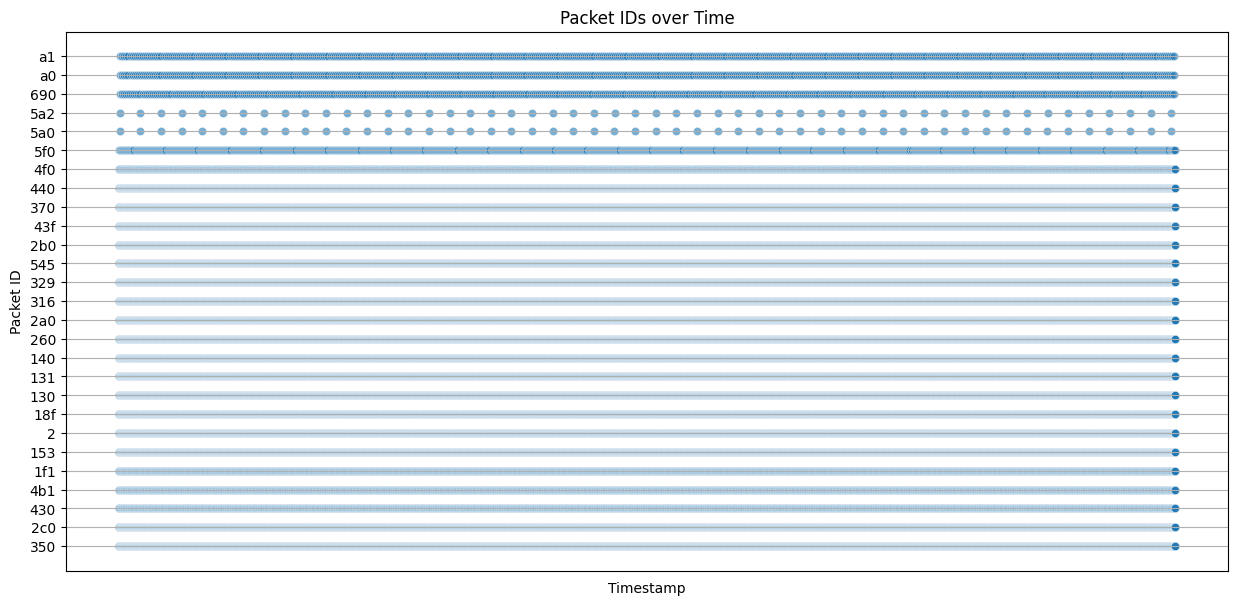

In [72]:
plt.figure(figsize=(15, 7))
plt.scatter(normal_data['Timestamp'], normal_data['ID'], alpha=0.6, edgecolors='w', linewidth=0.5)
plt.xlabel('Timestamp')
plt.ylabel('Packet ID')
plt.xticks([])
plt.title('Packet IDs over Time')
plt.grid(True)
plt.show()

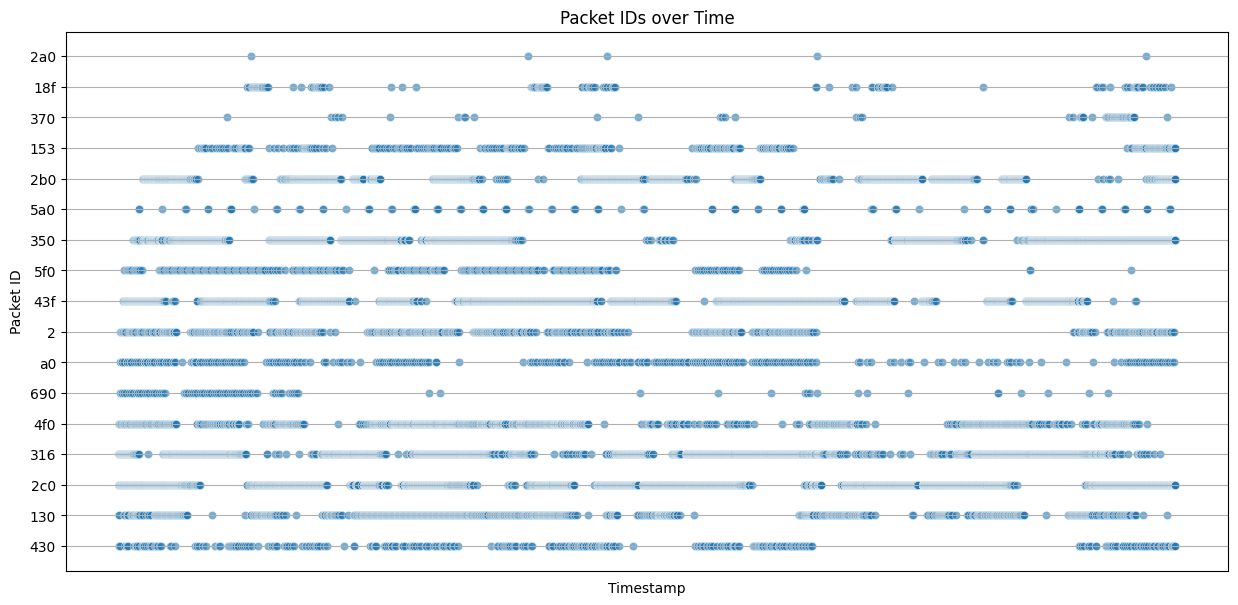

In [73]:
plt.figure(figsize=(15, 7))
plt.scatter(attacks['Timestamp'], attacks['ID'], alpha=0.6, edgecolors='w', linewidth=0.5)
plt.xlabel('Timestamp')
plt.ylabel('Packet ID')
plt.xticks([])
plt.title('Packet IDs over Time')
plt.grid(True)
plt.show()

In [58]:
normal_data[:10_000][normal_data[:10_000]['ID'] == 848].sample(1)

ValueError: a must be greater than 0 unless no samples are taken

In [82]:
normal_data[normal_data['DLC'] != 8]['ID'].unique()

array(['2b0', '5f0'], dtype=object)

In [21]:
normal_data["Timestamp"].iloc[1]

1479121434.850423

In [24]:
len(normal_data)

988871

In [94]:
atr_dict = dict()

"""data : The dataflow until the time at which decision to inject packet is taken"""

ids = list(periodicity_dict.keys())

last_occurrences = data.drop_duplicates(subset='ID', keep='last')

for id in ids:

    last_occurrence = last_occurrences[last_occurrences['ID'] == id]['Timestamp']
    
    atr = (ts - last_occurrence)/periodicity_dict[id]

    if len(atr.values) == 0:
        atr = 0.0
    else:
        atr = atr.item()
    
    atr_dict[id] = atr